# First Steps into using *pyforce*

*pyforce* is a Python package for data-driven reduced order modelling approaches built upon scientific computing libraries such as `numpy`, `scipy`, `scikit-learn` and `pyvista`. The main goal of *pyforce* consists in providing a rather simple and intuitive interface for researchers on this topic: even though the main focus of the authors is on nuclear reactors multi-physics scenarios (including fluid dynamics and neutronics mainly), the package is designed to be applicable to a wide range of problems in scientific computing and engineering.

This notebook wants to provide a first hands-on introduction to some basics classes and methods, which are needed to effectively use *pyforce* for your own applications. Before proceeding, this notebook supposes the reader has a basic knowledge of the ROM terminology.

In particular, in this tutorial you will learn how to:

- Generate custom snapshots on a `pyvista` grid and save them into `FunctionsList` objects (basic class using by *pyforce* to store data).
- Basic Plotting of `FunctionsList`.
- Write and read snapshots from disk using *pyforce* I/O functions.
- Calculate integral using `IntegralCalculator` class.

For interested users in high-dimensional data, this notebook also shows how to read decomposed snapshots generated by OpenFOAM.

## Basics of the `FunctionsList` class
In this section, we are going to load an example mesh from `pyvista` and generate custom snapshots on it, exploring some basic functionalities of the `FunctionsList` class.

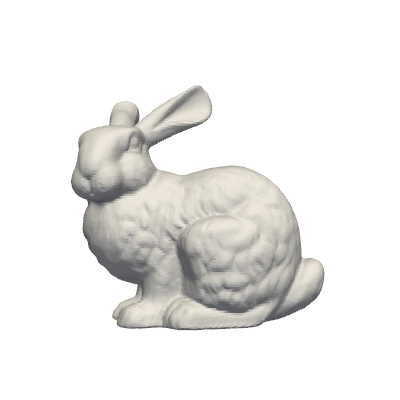

In [1]:
from pyvista import examples
import pyvista as pv
import numpy as np

grid = examples.download_bunny()

# Extract the points of the grid
nodes = grid.points

pl = pv.Plotter(window_size=[400, 400])
pl.add_mesh(grid, show_edges=False, color='white')
pl.view_xy()
pl.show(jupyter_backend='static') # jupyter_backend='html', 'trame'

Let $\mathbf{x}=(x,y,z)$ be the spatial coordinate of the mesh nodes, we are going to define a custom function, dependent on $\mathbf{x}$ and on a parameter $\mu$, as follows:
\begin{equation*}
f(x,y,z;\,\mu) = \sin\!\Big( \mu \sqrt{x^2 + y^2} + 5 \,\arctan\!\frac{y}{x} +\mu z\Big)
\end{equation*}

The `FunctionsList` class is used to store the snapshots, and it can be initialized by providing the number of nodes of the mesh. Snapshots can be appended to the `FunctionsList` object by using the `append` method.

In [2]:
from pyforce.tools.functions_list import FunctionsList

# Definining the function
def combo_field(coords, mu):
    x, y, z = coords.T
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.sin(mu * r + 5*theta + mu*z)

# Initialization of the class
snapshots = FunctionsList(nodes.shape[0])

mu_samples = np.linspace(100, 200, 100)
for mu in mu_samples:
    snapshots.append(combo_field(nodes, mu=mu))

The `FunctionsList` comes with a plotting method, which can be used to visualize the sequence of snapshots.

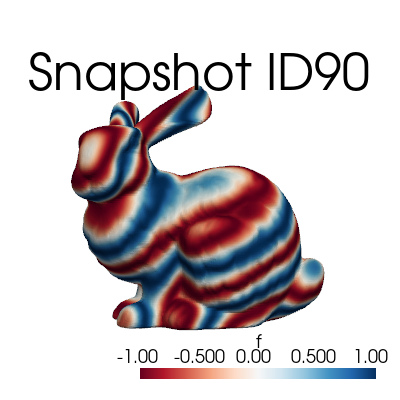

In [3]:
snapshots.plot_sequence(grid, 
                        sampling=5, view='xy', cmap='RdBu', resolution=[400,400], title='Snapshot ID', varname='f',  # optional
                        )

The class comes also with a method to plot a single snapshot, by providing its index in the list.

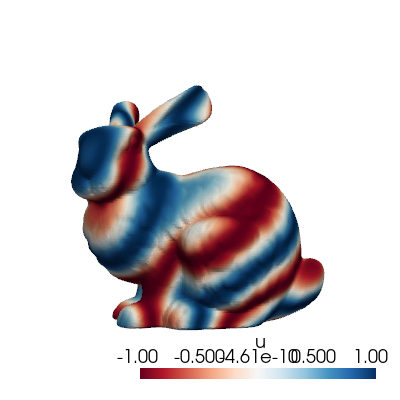

In [4]:
snapshots.plot(grid, idx_to_plot=10, 
                cmap='RdBu', resolution=[400,400] # optional
                )

Before delving into the I/O functionalities, let's mention some useful methods of the `FunctionsList` class:

- `return_matrix`: Returns the stored snapshots as a 2D NumPy array, whose shape is `(n_space, n_snapshots)` $\longleftrightarrow (\mathcal{N}_h, N_s)$.
- `build_from_matrix`: Builds the snapshot list from a 2D NumPy array, whose shape is `(n_space, n_snapshots)`.
- `lin_combine`: Linearly combines the stored snapshots using given coefficients (useful for reduced basis approximation). Consider $\boldsymbol{\alpha}\in N_s$, the elements $f_i$ of the `FunctionsList` are linearly combined as follows:
\begin{equation*}
F(\mathbf{x}) = \sum_{i=1}^{N_s} \alpha_i f_i(\mathbf{x})
\end{equation*}
- `min`, `max`, `mean`, `std`: Returns the minimum, maximum, mean and standard deviation of the stored snapshots, respectively.

## I/O methods within *pyforce*
In this section, we are going to explore the I/O functionalities of *pyforce*.

Starting from the `FunctionsList` object generate before, we can store them using the `store` method. The data can be store in `h5` or `npz` format (either compressed or not).

In [5]:
snapshots.store(var_name='f', 
                filename='example_snaps', 
                format = 'h5', 
                compression=True)

snapshots.store(var_name='f', 
                filename='example_snaps', 
                format = 'npz', 
                compression=True)

Once the data, these can be loaded with the `ImportFunctionsList` function.

In [6]:
from pyforce.tools.write_read import ImportFunctionsList

snaps_h5 = ImportFunctionsList('example_snaps', format='h5')
snaps_npz = ImportFunctionsList('example_snaps', format='npz')

# Check if the import was successful
np.max(np.abs(snaps_h5.return_matrix() - snapshots.return_matrix())), np.max(np.abs(snaps_npz.return_matrix() - snapshots.return_matrix()))

# Clean up
! rm example_snaps.*

The *pyforce* package provides also a class to import snapshots from an OpenFOAM simulation through the `ReadFromOF` class: this class will be explained in details in future tutorials since it will be extended used.

## Integral Calculations
Integrals can be calculated through the `IntegralCalculator` class: in this section, we are going to explore its functionalities.

At first, let us load a grid from the [cavity problem](https://www.openfoam.com/documentation/tutorial-guide/2-incompressible-flow/2.1-lid-driven-cavity-flow).


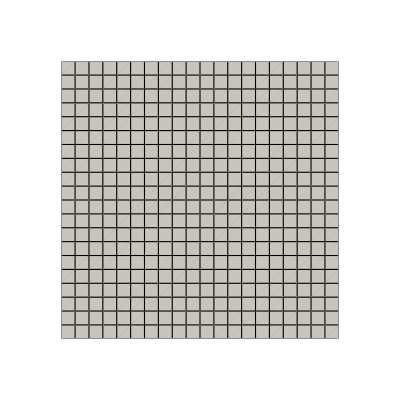

In [7]:
from pyvista import examples
grid  = examples.download_cavity()['internalMesh']
grid.clear_data()

pl = pv.Plotter(window_size=[400, 400])
pl.add_mesh(grid, show_edges=True, color='white')
pl.view_xy()
pl.show(jupyter_backend='static') # jupyter_backend='html', 'trame'

Let us consider two functions:
\begin{equation*}
\begin{split}
u(x,y) &= x^2+y^2 \\
v(x,y) &= x^3 + y
\end{split}
\end{equation*}
and evaluate them on the cavity grid.

A plot using `matplotlib` is also provided.

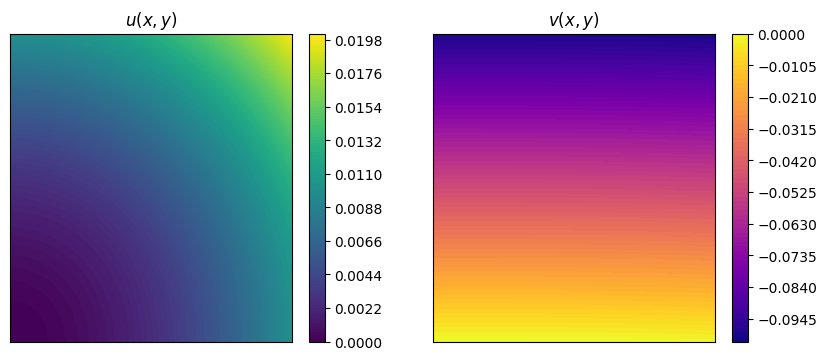

In [8]:
nodes = grid.points

u = nodes[:, 0]**2 + nodes[:, 1]**2
v = -nodes[:, 0]**3 - nodes[:, 1]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(10,4))

cont_u = axs[0].tricontourf(nodes[:,0], nodes[:,1], u, levels=100, cmap="viridis")
cbar_u = fig.colorbar(cont_u, ax=axs[0])
axs[0].set_title('$u(x,y)$')

cont_v = axs[1].tricontourf(nodes[:,0], nodes[:,1], v, levels=100, cmap="plasma")
cbar_v = fig.colorbar(cont_v, ax=axs[1])
axs[1].set_title('$v(x,y)$')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

The `IntegralCalculator` class can be initialized by providing the grid. There are different integrals that can be computed, such as ($\Omega$ is the spatial domain, which is $[0,1/10]\times[0,1/10]\times[0,1/100]$ in this case):

\begin{equation*}
\begin{split}
\text{Integral:} \quad & \int_\Omega u(x,y) \, d\Omega =  \Delta z \cdot \frac{2}{10} \cdot \frac{1}{3000} = \Delta z \cdot \frac{1}{15000} \\
\text{Average:} \quad & \frac{1}{|\Omega|} \int_\Omega u(x,y) \, d\Omega = ... = \frac{1}{\Delta x\cdot \Delta y\cdot \Delta z}\Delta z \cdot \frac{1}{15000} = \frac{1}{150}\\
L^1\text{-norm:} \quad & \|v\|_{L^1(\Omega)}=\int_\Omega |v(x,y)| \, d\Omega\\
L^2\text{ inner product:} \quad & (u,v)_{L^2(\Omega)}=\int_\Omega u(x,y)\cdot v(x,y) \, d\Omega\\
L^2\text{-norm:} \quad & \|u\|_{L^2(\Omega)}=\sqrt{\int_\Omega u(x,y)^2 \, d\Omega}
\end{split}
\end{equation*}

In [9]:
from pyforce.tools.backends import IntegralCalculator

calc = IntegralCalculator(grid, gdim = 3)

integrals = {
    'integral': calc.integral(u),
    'average ': calc.average(u),
    'L1_norm ': calc.L1_norm(v),
    'L2_inner': calc.L2_inner_product(u, v),
    'L2_norm ': calc.L2_norm(u)
}

for key, value in integrals.items():
    print(f"{key}: {value:.8e}")

integral: 6.67500029e-07
average : 6.67500024e-03
L1_norm : 5.02506261e-06
L2_inner: -4.19379194e-08
L2_norm : 7.89163352e-05


### Trick to handle 1D datasets

*pyforce* has been mainly designed to handle high-dimensional datasets (2D/3D). However, it is possible to use the `IntegralCalculator` class also for 1D datasets, by exploiting a simple trick: we can embed the 1D data into a 3D grid with unitary thickness in the unused directions.

In [13]:
import numpy as np
import pyvista as pv

nx = 10000
x_min, x_max = -1.0, 2.0
dx = (x_max - x_min) / nx   # size in x
dy = dx                     # size in y
dz = dx                     # size in z

x = np.linspace(x_min, x_max, nx).reshape((nx, 1, 1))

grid = pv.ImageData()
grid.dimensions = np.array(x.shape) + 1    # (nx+1, 2, 2)
grid.origin = (x_min, 0.0, 0.0)            # optional
grid.spacing = (dx, dy, dz)

fun = (x**2 * (1 - x)**2).flatten()

calcu = IntegralCalculator(grid)
calcu.cell_sizes = calcu.cell_sizes / dx**2

print('Exact integral value                   = ', 2.1)
print('Numpy Integration with trapezoid rule  = ', np.trapezoid(fun, x[:, 0, 0]))
print('Numpy Integration with reactangle rule = ', np.sum(fun) * dx)
print('Pyforce Integration with 3D trick      = ', calcu.integral(fun))

Exact integral value                   =  2.1
Numpy Integration with trapezoid rule  =  2.1000001800360044
Numpy Integration with reactangle rule =  2.1009901800180018
Pyforce Integration with 3D trick      =  2.1009901800180018


## Reading and post-processing decomposed OpenFOAM data with *pyforce*
This part demonstrates how to read and post-process decomposed OpenFOAM data using the *pyforce* library: in particular, we will read a decomposed case, reconstruct the data, and visualize it.

Furthermore, we will show how to compute average values and fluctuations of a field over time.

The class `ReadFromOF` from the module `pyforce.tools.write_read` allows reading OpenFOAM cases, including decomposed ones, by setting the parameter `decomposed_case=True`.

Case Type decomposed


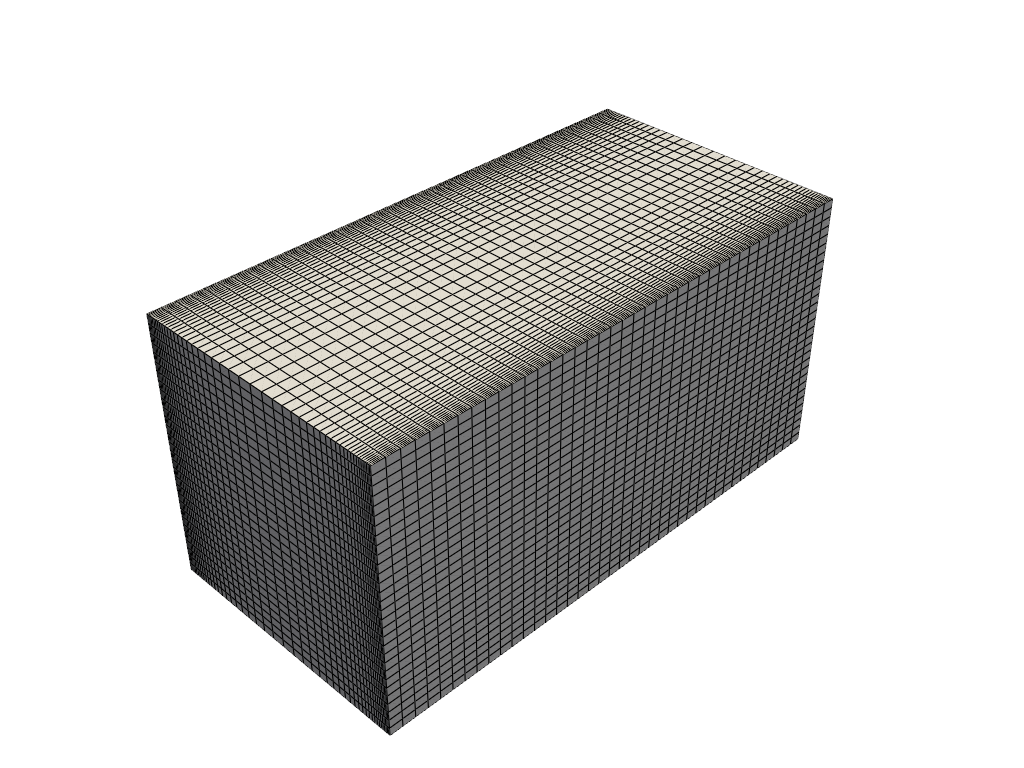

In [4]:
from pyforce.tools.write_read import ReadFromOF

of = ReadFromOF('Datasets/channel395_OF11', skip_zero_time=True, decomposed_case=True)
grid = of.mesh()

import pyvista as pv

pl = pv.Plotter()
pl.add_mesh(grid, show_edges=True, color='white')
pl.show(jupyter_backend='static')

Let us import the velocity and pressure fields

In [5]:
import numpy as np
var_names = ['U', 'p']

snaps = dict()
times = dict()

for field in var_names:
    _snap, time = of.import_field(field, use_fluidfoam=False, verbose=True, extract_cell_data=True)
    snaps[field] = _snap
    times[field] = time
    print(' ')

Importing U using pyvista: 200.000 / 200.00 - 0.021210 s/it
 
Importing p using pyvista: 200.000 / 200.00 - 0.017778 s/it
 


Let us make in-notebook video of the slice at mid-depth of the channel over time

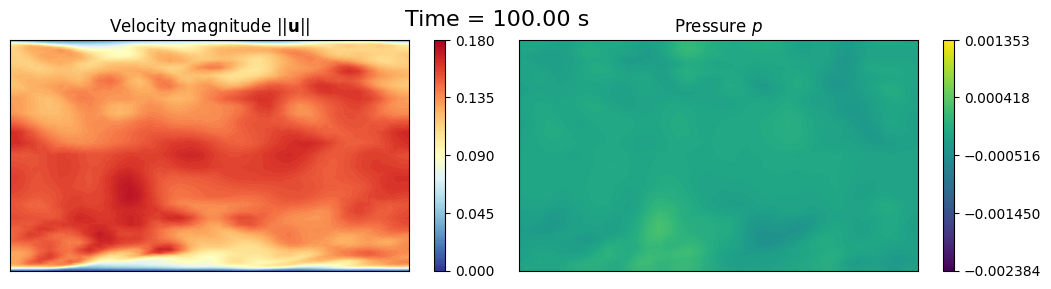

In [6]:
def get_slice_data(grid: pv.UnstructuredGrid, snap):
    grid['fun'] = snap
    _new_grid = grid.cell_data_to_point_data()
    slice = _new_grid.slice(normal='z', origin=(0, 0.0, 1.))
    grid.clear_data()
    return slice.points, slice['fun']

import matplotlib.pyplot as plt
from IPython.display import clear_output as clc

sampling = 10
for tt in range(sampling-1, len(times['U']), sampling):

    height_2_width_ratio = grid.bounds[5] / (grid.bounds[1] - grid.bounds[0])
    fig, axs = plt.subplots(1, 2, figsize=(6.5 * 2, 6 * height_2_width_ratio))

    # Velocity
    _sliced_points, _sliced_data = get_slice_data(grid, snaps['U'][tt].reshape(-1, 3))
    _sliced_data = np.linalg.norm(_sliced_data, axis=1)
    sc1 = axs[0].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=np.linspace(0, 0.18, 100), cmap='RdYlBu_r')
    cbar = fig.colorbar(sc1, ax=axs[0])
    cbar.ax.set_yticks(np.linspace(0, 0.18, 5))
    axs[0].set_title(r'Velocity magnitude $||\mathbf{u}||$')

    # Pressure
    _sliced_points, _sliced_data = get_slice_data(grid, snaps['p'][tt])
    sc2 = axs[1].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=np.linspace(snaps['p'].min(), snaps['p'].max(), 100), cmap='viridis')
    cbar = fig.colorbar(sc2, ax=axs[1])
    cbar.ax.set_yticks(np.linspace(snaps['p'].min(), snaps['p'].max(), 5))
    axs[1].set_title(r'Pressure $p$')

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(f'Time = {times["U"][tt]:.2f} s', fontsize=16)
    fig.subplots_adjust(wspace=0.02)

    plt.show()
    clc(wait=True)
    plt.close()

### Mean Field
The *fieldAverage* function object in OpenFOAM is used to compute the mean field $\overline{u}$ in a cumulative way, achieving better accuracy over time. The mean field is calculated as:
$$
\overline{u}(t) = \frac{1}{t - t_0} \int_{t_0}^{t} u(\tau) d\tau
$$
where $t_0$ is the start time for averaging. A discrete version of this equation is implemented in OpenFOAM using a uniform time step $\Delta t$:
$$
\overline{u}_n \approx \frac{1}{N_t} \sum_{k=1}^{N_t} u_k
$$
at time $t=t_n$, where $N_t$ is the number of time steps from $t_0$ to $t_n$. 

We want to investigate is the *a-posteriori* mean field computed using python and compare it with the mean field computed by OpenFOAM.

Let us import the mean value at final time computed by OpenFOAM

Importing UMean using pyvista: 1.000 / 1.00 - 0.000165 s/it


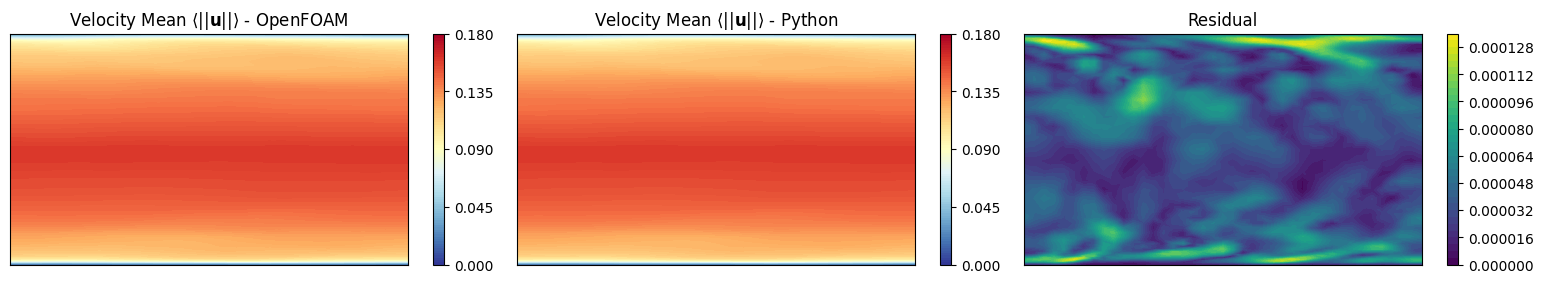

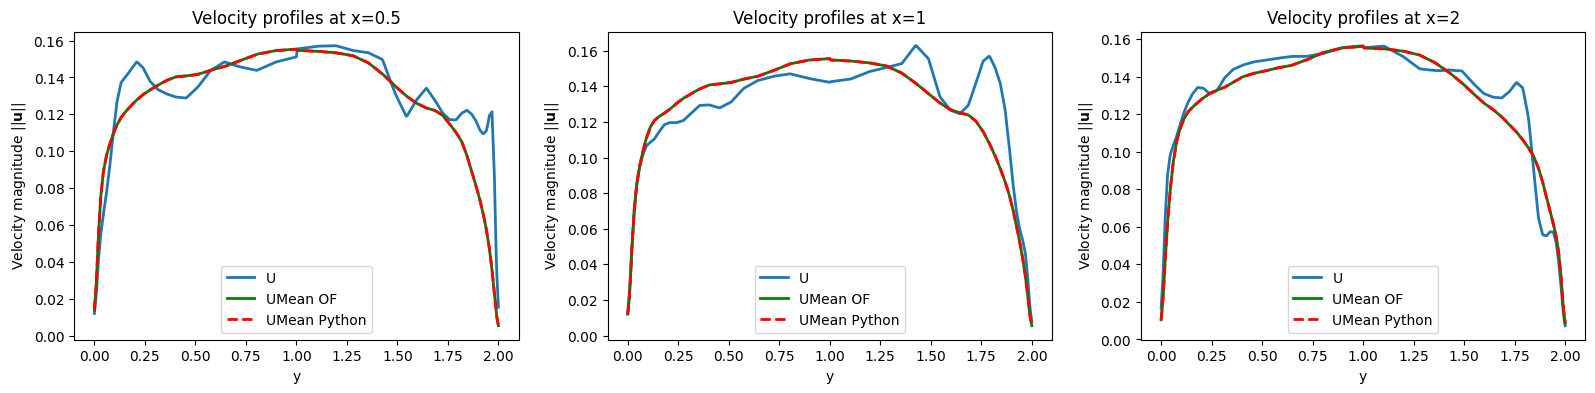

In [43]:
umean_of = of._import_with_pyvista('UMean', extract_cell_data=True, time_instants=[100])[0][0]
umean_python = snaps['U'].mean(axis=1).reshape(-1, 3)

fig, axs = plt.subplots(1, 3, figsize=(6.5 * 3, 6 * height_2_width_ratio))

# Velocity Mean OpenFOAM
_sliced_points, _sliced_data = get_slice_data(grid, umean_of)
_sliced_data = np.linalg.norm(_sliced_data, axis=1)
sc1 = axs[0].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=np.linspace(0, 0.18, 100), cmap='RdYlBu_r')
cbar = fig.colorbar(sc1, ax=axs[0])
cbar.ax.set_yticks(np.linspace(0, 0.18, 5))
axs[0].set_title(r'Velocity Mean $\langle||\mathbf{u}||\rangle$ - OpenFOAM')

# Velocity Mean Python
_sliced_points, _sliced_data = get_slice_data(grid, umean_python)
_sliced_data = np.linalg.norm(_sliced_data, axis=1)
sc2 = axs[1].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=np.linspace(0, 0.18, 100), cmap='RdYlBu_r')
cbar = fig.colorbar(sc2, ax=axs[1])
cbar.ax.set_yticks(np.linspace(0, 0.18, 5))
axs[1].set_title(r'Velocity Mean $\langle||\mathbf{u}||\rangle$ - Python')

# Residual
_sliced_points, _sliced_data = get_slice_data(grid, umean_of - umean_python)
_sliced_data = np.linalg.norm(_sliced_data, axis=1)
sc3 = axs[2].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=40, cmap='viridis')
cbar = fig.colorbar(sc3, ax=axs[2])
axs[2].set_title('Residual')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(wspace=0.02)
plt.show()

grid.clear_data()
grid['U'] = snaps['U'](-1).reshape(-1, 3)
grid['UMean_OF'] = umean_of
grid['UMean_Python'] = umean_python

lines_x = [0.5, 1, 2]
line_grid = [grid.cell_data_to_point_data().sample_over_line(pointa = (x, 0.0, 0), pointb=(x, 2, 0), resolution=500) for x in lines_x]

fig, axs = plt.subplots(1, len(lines_x), figsize=(6.5 * len(lines_x), 4))

for ii, ax in enumerate(axs):
    ax.plot(line_grid[ii]['Distance'], np.linalg.norm(line_grid[ii]['U'], axis=1), label='U', linewidth=2)
    ax.plot(line_grid[ii]['Distance'], np.linalg.norm(line_grid[ii]['UMean_OF'], axis=1), 'g-', label='UMean OF', linewidth=2)
    ax.plot(line_grid[ii]['Distance'], np.linalg.norm(line_grid[ii]['UMean_Python'], axis=1), 'r--', label='UMean Python', linewidth=2)
    ax.set_title(f'Velocity profiles at x={lines_x[ii]}')
    ax.set_xlabel('y')
    ax.set_ylabel(r'Velocity magnitude $||\mathbf{u}||$')
    ax.legend()

### prime2Mean Field - Variance Field
The *prime2MeanField* function object computes the variance field $\overline{u'u'}$ based on the mean field $\overline{u}$ calculated using *fieldAverage*. The variance field is defined as:
$$
\overline{u'u'}(t) = \frac{1}{t - t_0} \int_{t_0}^{t} (u(\tau) - \overline{u}(\tau))^2 d\tau
$$
In discrete form, this is approximated as (unbiased estimator):
$$
\overline{u'u'}_n \approx \frac{1}{N_t-1} \sum_{k=1}^{N_t-1} (u_k - \overline{u}_k)^2
$$
at time $t=t_n$. This calculation relies on the mean field values at each time step to determine the fluctuations $u' = u - \overline{u}$.

We want to investigate is the *a-posteriori* prime2mean field computed using python and compare it with the prime2mean field computed by OpenFOAM.


In particular, the Welford's method is used to compute the variance $\overline{u'u'}_n$, without storing all the snapshots in the memory.
Two variables are protagonists of this method: `running_mean`$\leftrightarrow\overline{u}_n$ and `running_M2`$\leftrightarrow M_{2,n}$, in which the former stores the mean value at each time step, while the latter accumulates the squared differences needed to compute the variance.

1. Calculation of the deviation from the old mean $\delta = u_n - $\overline{u}_{n-1}$, current instantaneous velocity is from the current average history.
2. Update the mean: $\overline{u}_n = \overline{u}_{n-1} + \delta/n$, clearly for $n\rightarrow +\infty$ the correction term goes to zero and this obtain to $\overline{u}_n \approx \overline{u}_{n-1}\rightarrow\overline{u}$.
3. Calculation of the deviation from the new mean $\delta_\dagger = u_n - \overline{u}_n$.
4. Accumulate the squared differences: $M_{2,n} = M_{2,n-1} + \delta \cdot \delta_\dagger$.
5. Estimate the variance: $\overline{u'u'}_n = M_{2,n}/(n-1)$ (unbiased estimator, even though OpenFOAM uses $n$ in the denominator but this approach is more statistically sound).

Two implementations are provided: one using pure `numpy` operations, and another one using `torch` for GPU acceleration (**not reported in the package requirements, if needed please install it separately**).

In [17]:
import torch
import numpy as np
from tqdm import tqdm
from pyforce.tools.functions_list import FunctionsList

def welford_variance_torch(velocity_snapshots: FunctionsList, gdim = 3, sampling = 1):

    device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
    
    n_snaps = len(velocity_snapshots)
    n_cells = int(velocity_snapshots.fun_shape / gdim)

    # Initialize running stats on GPU
    running_mean = torch.zeros((n_cells, gdim), device=device, dtype=torch.float32)
    running_M2 = torch.zeros((n_cells, gdim), device=device, dtype=torch.float32)
    
    # Counter
    count = 0

    # Output container (numpy on CPU)
    uprime2mean = np.zeros((int((n_snaps - 1) / sampling), n_cells, gdim))

    # Loop through data one snapshot at a time
    for t in tqdm(range(sampling-1, n_snaps, sampling), desc='Welford Variance Calculation - Torch'):

        # Load ONLY the current snapshot to GPU
        u_new = torch.from_numpy(velocity_snapshots[t].reshape(-1, gdim)).to(device)
        count += 1

        # 1. Delta from the OLD mean
        delta = u_new - running_mean

        # 2. Update the mean
        running_mean += delta / count

        # 3. Delta from the NEW mean
        delta_dagger = u_new - running_mean

        # 4. Update Sum of Squares (M2)
        running_M2 += delta * delta_dagger

        # 5. Calculate Variance (Prime2Mean) and Save
        if count > 1:
            current_variance = running_M2 / (count - 1)
            uprime2mean[int((t-1) / sampling), :] = current_variance.cpu().numpy()

    # Clean up GPU memory if needed
    del running_mean, running_M2, u_new
    if device == 'cuda':
        torch.cuda.empty_cache()
    elif device == 'mps':
        torch.mps.empty_cache()

    return uprime2mean

def welford_variance_numpy(velocity_snapshots: FunctionsList, gdim = 3, sampling = 1):

    n_snaps = len(velocity_snapshots)
    n_cells = int(velocity_snapshots.fun_shape / gdim)

    # Initialize running stats
    running_mean = np.zeros((n_cells, gdim), dtype=np.float32)
    running_M2 = np.zeros((n_cells, gdim), dtype=np.float32)
    
    # Counter
    count = 0

    # Output container
    uprime2mean = np.zeros((int((n_snaps - 1) / sampling), n_cells, gdim))

    # Loop through data one snapshot at a time
    for t in tqdm(range(sampling-1, n_snaps, sampling), desc='Welford Variance Calculation - Numpy'):

        # Load ONLY the current snapshot
        u_new = velocity_snapshots[t].reshape(-1, gdim)
        count += 1

        # 1. Delta from the OLD mean
        delta = u_new - running_mean

        # 2. Update the mean
        running_mean += delta / count

        # 3. Delta from the NEW mean
        delta_dagger = u_new - running_mean

        # 4. Update Sum of Squares (M2)
        running_M2 += delta * delta_dagger

        # 5. Calculate Variance (Prime2Mean) and Save
        if count > 1:
            current_variance = running_M2 / (count - 1)
            uprime2mean[int((t-1) / sampling), :] = current_variance

    return uprime2mean

uprime2mean_torch = welford_variance_torch(snaps['U'], gdim=3, sampling=1)
uprime2mean_numpy = welford_variance_numpy(snaps['U'], gdim=3, sampling=1)

# Load UPrim2Mean from OpenFOAM for comparison
uprime2mean_of = of._import_with_pyvista('UPrime2Mean', extract_cell_data=True, time_instants=[100])[0][0]

Welford Variance Calculation - Numpy: 100%|██████████| 200/200 [00:00<00:00, 3406.75it/s]

Importing UPrime2Mean using pyvista: 1.000 / 1.00 - 0.000122 s/it


Let us make some contour plots

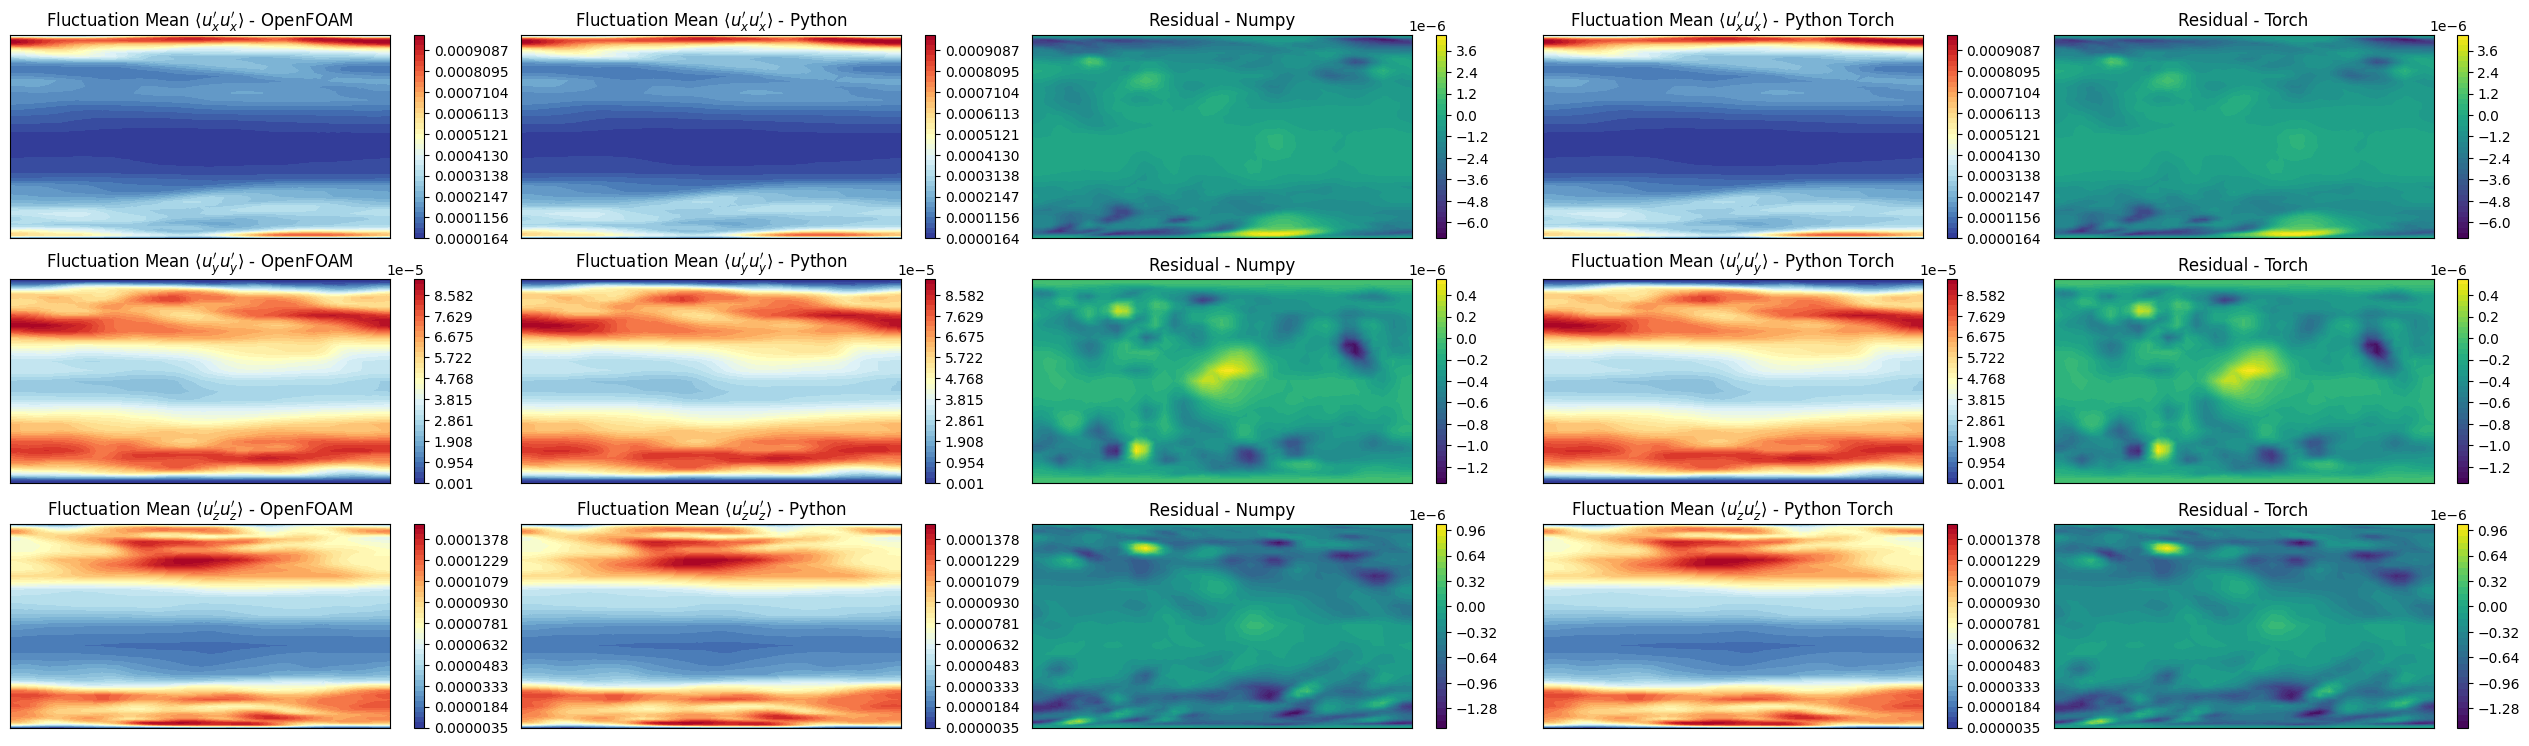

In [27]:
fig, axs = plt.subplots(3,5, figsize=(6.5 *5, 6 * 3 * height_2_width_ratio))

symmtensor_idx = [0,1,2]
labels = ['x', 'y', 'z']

for ii, label in enumerate(labels):
    
    # UPrime2Mean OpenFOAM
    _sliced_points, _sliced_data = get_slice_data(grid, uprime2mean_of[:, symmtensor_idx[ii]])
    levels = np.linspace(_sliced_data.min(), _sliced_data.max(), 40)
    sc1 = axs[ii,0].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=levels, cmap='RdYlBu_r')
    cbar = fig.colorbar(sc1, ax=axs[ii,0])
    axs[ii,0].set_title(r"Fluctuation Mean $\langle u"+f"_{label}' u"+f"_{label}' \\rangle$ - OpenFOAM")

    # UPrime2Mean Python - Numpy
    _sliced_points, _sliced_data = get_slice_data(grid, uprime2mean_numpy[-1, :, ii])
    sc2 = axs[ii,1].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=levels, cmap='RdYlBu_r')
    cbar = fig.colorbar(sc2, ax=axs[ii,1])
    axs[ii,1].set_title(r"Fluctuation Mean $\langle u"+f"_{label}' u"+f"_{label}' \\rangle$ - Python")

    # Residual - Numpy
    _sliced_points, _sliced_data = get_slice_data(grid, uprime2mean_of[:, symmtensor_idx[ii]] - uprime2mean_numpy[-1, :, ii])
    sc3 = axs[ii,2].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=40, cmap='viridis')
    cbar = fig.colorbar(sc3, ax=axs[ii,2])
    axs[ii,2].set_title(f'Residual - Numpy')

    # UPrime2Mean Python - Torch
    _sliced_points, _sliced_data = get_slice_data(grid, uprime2mean_torch[-1, :, ii])
    sc4 = axs[ii,3].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=levels, cmap='RdYlBu_r')
    cbar = fig.colorbar(sc4, ax=axs[ii,3])
    axs[ii,3].set_title(r"Fluctuation Mean $\langle u"+f"_{label}' u"+f"_{label}' \\rangle$ - Python Torch")

    # Residual - Torch
    _sliced_points, _sliced_data = get_slice_data(grid, uprime2mean_of[:, symmtensor_idx[ii]] - uprime2mean_torch[-1, :, ii])
    sc5 = axs[ii,4].tricontourf(_sliced_points[:, 0], _sliced_points[:, 1], _sliced_data, levels=40, cmap='viridis')
    cbar = fig.colorbar(sc5, ax=axs[ii,4])
    axs[ii,4].set_title(f'Residual - Torch')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(wspace=0.075)

Let's observe if the python solution converges to the OpenFOAM one as we increase the number of snapshots used in the calculation

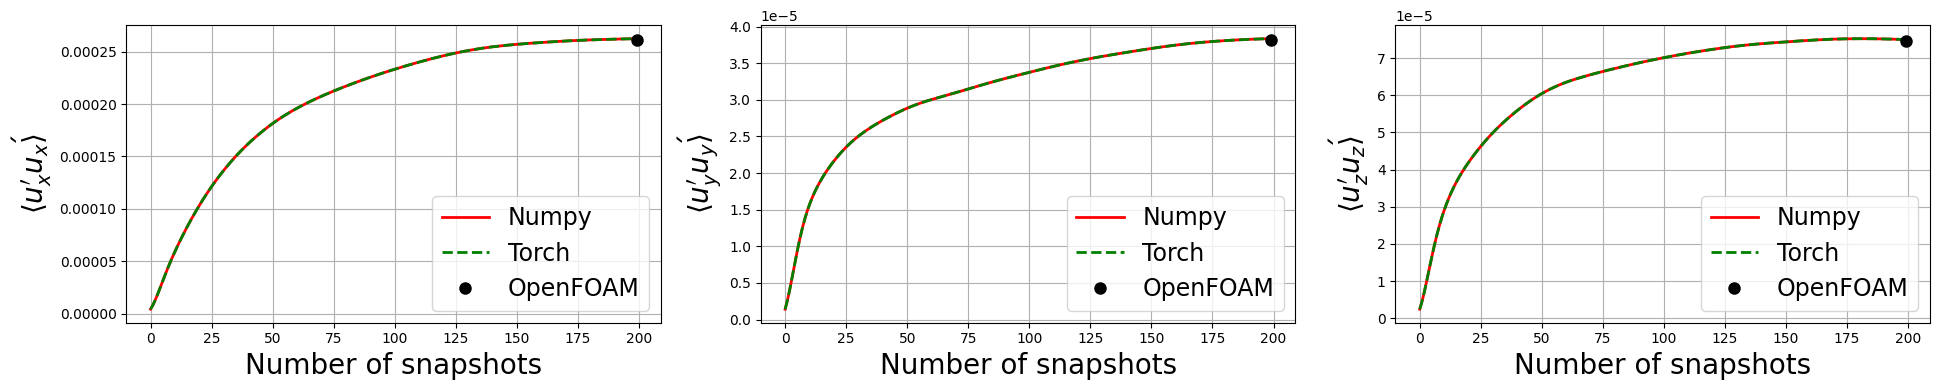

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(6.5 * 3, 4))

for ii, label in enumerate(labels):
    axs[ii].plot(uprime2mean_numpy[:, :, ii].mean(axis=1), 'r', label=f'Numpy', linewidth=2)
    axs[ii].plot(uprime2mean_torch[:, :, ii].mean(axis=1), 'g--', label=f'Torch', linewidth=2)
    axs[ii].plot([len(uprime2mean_numpy[:, ii])], uprime2mean_of[:, symmtensor_idx[ii]].mean(), 'ko', label=f'OpenFOAM', markersize=8)
    
    axs[ii].set_xlabel('Number of snapshots', fontsize=20)
    axs[ii].set_ylabel(r'$\langle u_{'+f'{label}'+'}\' u_{'+f'{label}'+r'}\' \rangle$', fontsize=20)
    axs[ii].legend(fontsize=17)

    axs[ii].grid()

plt.tight_layout()

### Energy Spectrum of the fluctuations

This last section shows how to compute the energy spectrum of the velocity fluctuations from OpenFOAM data. OpenFOAM generally reasons with unstructured meshes, hence the Fourier Transform cannot be directly applied. To overcome this issue, we interpolate the velocity fluctuations onto a structured grid, and then compute the energy spectrum using the Fast Fourier Transform (FFT). Let $u'(\mathbf{x},t)$ be the velocity fluctuations, the procedure is as follows:

1. Interpolate the velocity fluctuations onto a structured grid using `pyvista` method called `sample`, embedded in the method `map2structuredgrid` of the `ComputeSpectrum` class.
2. Compute the energy spectrum using FFT from `numpy.fft` module in the method `compute_spectrum` of the `ComputeSpectrum` class. The FFT is $\hat{u'}(\boldsymbol{\kappa},t) = \mathcal{F}\{u'(\mathbf{x},t)\}$, where $\boldsymbol{\kappa}$ is the wavevector in Fourier space. The energy spectrum $E(k)$ is then computed as:
\begin{equation*}
E(\boldsymbol{\kappa}) = \frac{1}{2} \sum_{i=x,y,z} \hat{u'}_i(\boldsymbol{\kappa},t)\cdot \hat{u'}_i^\dagger(\boldsymbol{\kappa},t) = \frac{1}{2} \sum_{i=x,y,z} |\hat{u'}_i(\boldsymbol{\kappa},t)|^2
\end{equation*}
where $\dagger$ denotes the complex conjugate.
3. Define the wave number $\boldsymbol{\kappa} = 2\pi \cdot \boldsymbol{\xi} = \frac{2\pi}{\mathbf{L}} \cdot \mathbf{n}$, where $\boldsymbol{\xi}$ is the spatial frequency vector, $\mathbf{L}$ is the physical length of the domain in each direction, and $\mathbf{n}$ is the integer vector corresponding to the discrete frequencies obtained from FFT and the magnitude $\kappa = |\boldsymbol{\kappa}| = \sqrt{\kappa_x^2 + \kappa_y^2 + \kappa_z^2}$ is computed.
4. **Shell Integration**: Kolmogorov theory assumes isotropy (direction doesn't matter). We want to know how much energy exists at a size scale k, regardless of direction. We transform the 3D "cloud" of energy into a 1D line by summing everything in spherical shells. 
   1. At first, the shell of bin $\Delta\kappa$ is defined as $\mathcal{S}_i = \{q | \kappa_i \leq |q| < \kappa_{i+1}\}$, where $\kappa_i = i \cdot \Delta\kappa$. 
   2. Summation (Discrete Integration): iterate through the bins and sums the energy of all modes that fall within each shell:
   \begin{equation*}
   E(\kappa_i) = \sum_{\boldsymbol{\kappa} \in \mathcal{S}_i} E(\boldsymbol{\kappa})
   \end{equation*}
   This approximates the integral definition of the isotropic energy spectrum:
   \begin{equation*}
   E(\kappa) = \int_{\mathcal{S}_\kappa} E(\boldsymbol{\kappa}) d\sigma
   \end{equation*}
   given the spherical shell $\mathcal{S}_\kappa = \{\boldsymbol{\kappa} \text{ such that } |\boldsymbol{\kappa}| = \kappa\}$.

[Reference Github repository for this section](https://github.com/saadgroup/TurboGenPY)

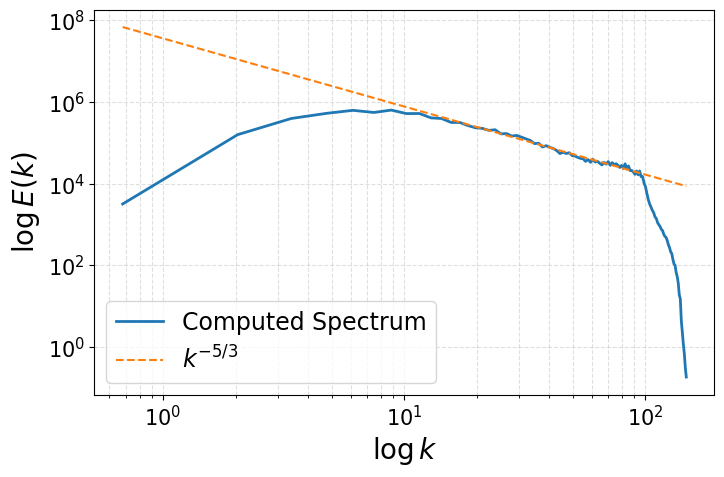

In [ ]:
from scipy.fft import fftn, fftfreq

class ComputeSpectrum:
    def __init__(self, u_mean, grid,
                 N = (128, 128, 128)):
        """
        u_mean: shape (Nh, 3)
        grid: pyvista grid object
        """

        self.umean = u_mean
        self.grid = grid # PyVista grid object - unstructured

        # Create structured grid
        self.Nx, self.Ny, self.Nz = N
        
        bounds = grid.bounds

        struct_grid = pv.ImageData()
        struct_grid.dimensions = (self.Nx, self.Ny, self.Nz)
        struct_grid.origin = (bounds[0], bounds[2], bounds[4])
        struct_grid.spacing = (
            (bounds[1]-bounds[0])/(self.Nx-1),
            (bounds[3]-bounds[2])/(self.Ny-1),
            (bounds[5]-bounds[4])/(self.Nz-1)
        )

        self.lx = bounds[1]-bounds[0]
        self.ly = bounds[3]-bounds[2]
        self.lz = bounds[5]-bounds[4]

        self.struct_grid = struct_grid

    def map2structuredgrid(self, u):
        self.grid.clear_data()
        self.grid['U'] = u

        U_field = self.struct_grid.sample(self.grid)['U'].reshape((self.Nz, self.Ny, self.Nx, 3)) # PyVista/VTK often orders as Z-Y-X
        U_field = np.transpose(U_field, (2,1,0,3))  # Now (Nx, Ny, Nz, 3) for FFT

        return U_field
    
    def compute_spectrum(self, u):

        U_field = self.map2structuredgrid(u)

        U_fft = fftn(U_field, axes=(0,1,2))

        # compute wave numbers
        kx = fftfreq(self.Nx, self.struct_grid.spacing[0]) * 2 * np.pi
        ky = fftfreq(self.Ny, self.struct_grid.spacing[1]) * 2 * np.pi 
        kz = fftfreq(self.Nz, self.struct_grid.spacing[2]) * 2 * np.pi

        # Compute energy spectrum
        E_spectrum = 0.5 * np.sum(np.abs(U_fft)**2, axis=-1)  # Sum over velocity components

        return E_spectrum, kx, ky, kz
    
    def movingaverage(self, interval, window_size):
        window = np.ones(int(window_size)) / float(window_size)
        return np.convolve(interval, window, 'same')
    
    def build_spectrum(self, u, smoothing_window=1):

        E_spectrum, kx, ky, kz = self.compute_spectrum(u)

        # Build 3D mesh of wave numbers
        KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')

        k_mag = np.sqrt(KX**2 + KY**2 + KZ**2)  # |k|
        k_flat = k_mag.flatten()
        E_flat = E_spectrum.flatten()

        k_max = k_flat.max()
        n_bins = int(np.floor(np.sqrt(self.Nx**2 + self.Ny**2 + self.Nz**2)))  # or ~min(Nx,Ny,Nz)/2

        # Linearly spaced bins (log bins also possible)
        k_bins = np.linspace(0, k_max, n_bins)

        E_k = np.zeros(n_bins - 1)
        k_center = np.zeros(n_bins - 1)

        for i in range(n_bins - 1):
            mask = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
            if np.any(mask):
                E_k[i] = E_flat[mask].sum()    
                k_center[i] = 0.5*(k_bins[i] + k_bins[i+1])

        if smoothing_window > 1: # apply moving average to smooth the spectrum
            E_k = self.movingaverage(E_k, smoothing_window)

        return k_center, E_k

generate_spectrum = ComputeSpectrum(umean_python, grid, N=(64,64,64))
k_center, E_k = list(), list()

# Compute spectra at last time step
u_fluct = snaps['U'](-1).reshape(-1, 3) - umean_python
k_center, E_k = generate_spectrum.build_spectrum(u_fluct, smoothing_window=3)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(8,5))

axs.plot(k_center, E_k, '-', linewidth=2, label='Computed Spectrum')

# Pick a constant so line overlaps your spectrum in inertial range
C = E_k[np.argmax(E_k)] * (k_center[np.argmax(E_k)]**(5/3))*1.5
axs.plot(k_center, C * k_center**(-5/3), '--', label=r'$k^{-5/3}$')

axs.set_xscale('log')
axs.set_yscale('log')
axs.legend(fontsize=17)
axs.tick_params(axis='both', which='major', labelsize=15)

axs.set_xlabel(r'$\log k$', fontsize=20)
axs.set_ylabel(r'$\log E(k)$', fontsize=20)
axs.grid(True, which='both', ls='--', alpha=0.4)

plt.show()